# Static tumbling neural network

## Imports

In [111]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical
import matplotlib.pyplot as plt

## Load and prepare the data

Import data from static tumbling csv file

In [2]:
static_tumbling = pd.read_csv('static-tumbling.csv')

## Separate the data into features and targets

In [3]:
elements, score = static_tumbling['elements'], static_tumbling['score']

### Generate global vocabulary

In [4]:
vocab = set()
for line in elements:
    for element in line.split(" "):
        vocab.add(element)
        
vocab = list(vocab)

Create dictionary to map each element to an index

In [5]:
word2idx = {word: i for i, word in enumerate(vocab)}

In [6]:
word2idx

{'arabe': 4,
 'flick': 5,
 'giro': 3,
 'giro2': 2,
 'layout': 1,
 'mortal': 6,
 'whip': 0}

### Text to vector fucntion

It will convert the elements to a vector of words

In [7]:
def text_to_vector(text):
    word_vector = np.zeros(len(vocab), dtype=np.int_)
    for element in text.split(' '):
        idx = word2idx.get(element, None)
        if idx is None:
            continue
        else:
            word_vector[idx] += 1
    return np.array(word_vector)

In [8]:
text_to_vector("arabe arabe flick")

array([0, 0, 0, 0, 2, 1, 0])

Convert all static tumbling passes to vectors

In [9]:
word_vectors = np.zeros((len(elements), len(vocab)), dtype=np.int_)
for ii, text in enumerate(elements):
    word_vectors[ii] = text_to_vector(text)

In [10]:
word_vectors

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 3, ..., 0, 1, 0],
       [0, 0, 2, ..., 0, 0, 1],
       [0, 0, 3, ..., 0, 0, 1]])

### Train, validation, Tests sets

Now that we have the word_vectors, we're ready to split our data into train, validation, and test sets. Remember that we train on the train data, use the validation data to set the hyperparameters, and at the very end measure the network performance on the test data.

In [11]:
Y = (score).astype(np.float_)
records = len(score)

shuffle = np.arange(records)
np.random.shuffle(shuffle)
test_fraction = 0.9

train_split, test_split = shuffle[:int(records*test_fraction)], shuffle[int(records*test_fraction):]
trainX, trainY = word_vectors[train_split,:], Y.values[train_split,None]
testX, testY = word_vectors[test_split,:], Y.values[test_split,None]

In [12]:
trainX

array([[0, 1, 1, ..., 0, 0, 2],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 2, 0],
       ..., 
       [0, 0, 0, ..., 0, 2, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 0, 2]])

In [13]:
trainY

array([[ 29.35  ],
       [ 17.75  ],
       [ 19.6   ],
       [ 16.15  ],
       [ 13.1   ],
       [ 17.3333],
       [ 19.1   ],
       [ 33.85  ],
       [ 18.6   ],
       [ 21.    ],
       [ 40.075 ],
       [ 23.1667],
       [ 16.25  ],
       [ 24.825 ],
       [ 22.6333],
       [ 21.325 ],
       [ 15.9333],
       [ 26.225 ],
       [ 17.8   ],
       [ 34.525 ],
       [ 20.95  ],
       [ 16.0333],
       [ 26.9   ],
       [ 20.3   ],
       [ 22.025 ],
       [ 25.3667],
       [ 23.1   ],
       [ 21.95  ],
       [ 28.15  ],
       [ 31.2333],
       [ 31.05  ],
       [ 34.8   ],
       [ 16.5   ],
       [ 21.    ],
       [ 33.825 ],
       [ 27.0333],
       [ 32.1   ],
       [ 23.9   ],
       [ 18.575 ],
       [ 27.6   ],
       [ 24.45  ],
       [ 29.3   ],
       [ 11.7667],
       [ 18.6   ],
       [ 22.425 ],
       [ 23.9   ],
       [ 20.    ],
       [  9.3   ],
       [ 22.4   ],
       [ 22.9   ],
       [ 30.3   ],
       [ 28.7   ],
       [ 25.

## Building the network

In [100]:
# Network building
def build_model():
    # This resets all parameters and variables, leave this here
    tf.reset_default_graph()
    
    #### Your code ####
    #Input
    net = tflearn.input_data([None, 7])
    #Hidden
    net = tflearn.fully_connected(net, 350, activation='sigmoid')
    net = tflearn.fully_connected(net, 50, activation='sigmoid')
    #output layer
    net = tflearn.fully_connected(net, 1, activation='linear')
    net = tflearn.regression(net, optimizer='sgd', loss='mean_square',metric='R2', learning_rate=0.001)
    model = tflearn.DNN(net)
    return model

### Initializing the model

In [101]:
model = build_model()

### Training the network

In [102]:
# Training
model.fit(trainX, trainY, validation_set=0.1, show_metric=True, batch_size=128, n_epoch=1000)

Training Step: 5999  | total loss: 0.92652 | time: 0.016s
| SGD | epoch: 1000 | loss: 0.92652 - R2: 1.0025 -- iter: 640/739
Training Step: 6000  | total loss: 0.90716 | time: 1.021s
| SGD | epoch: 1000 | loss: 0.90716 - R2: 1.0058 | val_loss: 0.62299 - val_acc: 1.0323 -- iter: 739/739
--


## Testing

In [119]:
# Helper function that uses your model to predict sentiment
def test_score(sentence):
    positive_prob = model.predict([text_to_vector(sentence.lower())])
    print('Gym pass: {}'.format(sentence))
    print('Score: {}'.format(positive_prob))
    print()
    return positive_prob

def test_compare(pass1, pass2):
    score1 = test_score(pass1)
    score2 = test_score(pass2)
    if score1 > score2:
        print('Gym pass 1: {}'.format(pass1))
    elif score2 > score1:
        print('Gym pass 2: {}'.format(pass1))
    else:
        print('same difficulty')
    

In [120]:
element1 = "mortal giro giro2 giro"
element2 = "mortal giro giro2 giro2 giro"

test_compare(element1,element2)

Gym pass: mortal giro giro2 giro
Score: [[36.82771682739258]]

Gym pass: mortal giro giro2 giro2 giro
Score: [[42.490169525146484]]

Gym pass 2: mortal giro giro2 giro


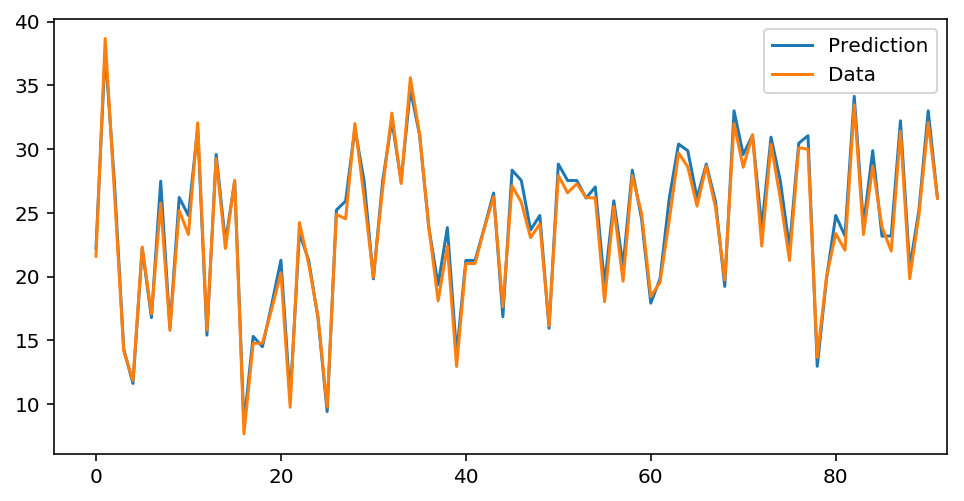

In [122]:
fig, ax = plt.subplots(figsize=(8,4))
predictions = model.predict(testX)
ax.plot(predictions,label='Prediction')
ax.plot(testY, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()